In [9]:
# extrae el catastro de cosecha, para poder ejecutar estimativas

In [10]:
import sys
sys.path.append('../')

In [11]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sqlalchemy import create_engine, MetaData, Table, text

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

In [12]:
USER_DB = POSTGRES_UTEA['USER']
PASS_DB = POSTGRES_UTEA['PASSWORD']
HOST_DB = POSTGRES_UTEA['HOST']
PORT_DB = POSTGRES_UTEA['PORT']
NAME_DB = POSTGRES_UTEA['DATABASE']

ENGINE = create_engine(f'postgresql+psycopg://{USER_DB}:{PASS_DB}@{HOST_DB}:{PORT_DB}/{NAME_DB}')

PATH_OUTPUT = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - AVANCE COSECHA\2025\ESTIMATIVAS\V06'

metadata = MetaData()

In [13]:
# obtiene todos los lotes de shp de cosecha
def get_lotes_cosecha():
    try:
        query = "SELECT * FROM catastro_iag.cosecha_2025"
        gdf = gpd.read_postgis(query, ENGINE, geom_col='geom')
        return gdf
    except Exception as e:
        print("❌ Error al leer datos de COSECHA 2025:", e)
        return pd.DataFrame()

# valida los campos de unidad_01, unidad_03 y unidad_05
def validar_campos(df):
    condiciones = (
        df["unidad_01"].notnull() & (df["unidad_01"] != 0) &
        df["unidad_03"].notnull() & (df["unidad_03"] != 0) &
        df["unidad_05"].notnull() & (df["unidad_05"].str.strip() != "")
    )
    return condiciones.all()

In [14]:
gdf_cosecha = get_lotes_cosecha()
gdf_cosecha['area'].sum()

55401.380000000005

In [15]:
if validar_campos(gdf_cosecha):
    print("✅ Todos los registros son válidos.")
else:
    print("❌ Hay registros inválidos.")

✅ Todos los registros son válidos.


In [16]:
# Convertir a string y concatena valores
gdf_cosecha['key'] = (
    gdf_cosecha['unidad_01'].astype(str) + "|" +
    gdf_cosecha['unidad_03'].astype(str) + "|" +
    gdf_cosecha['unidad_05'].astype(str)
)

In [17]:
gdf_cosecha_disuelto = gdf_cosecha.dissolve(by="key")
gdf_cosecha_disuelto = gdf_cosecha_disuelto.reset_index()
gdf_cosecha_disuelto["area"] = np.round(gdf_cosecha_disuelto.geometry.area / 10000, 2)
gdf_cosecha_disuelto['area'].sum()

55401.22

<Axes: >

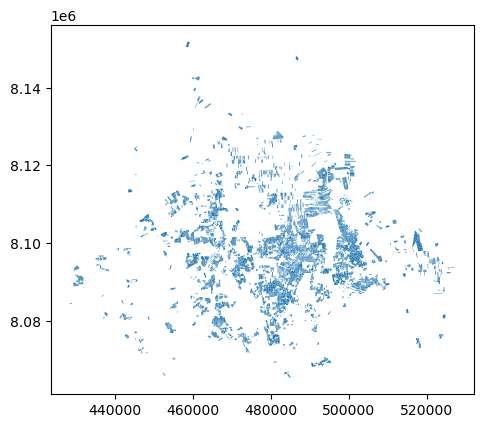

In [18]:
gdf_cosecha_disuelto.plot()

In [19]:
# convertir los campos fecha a str
gdf_cosecha_disuelto['fc'] = gdf_cosecha_disuelto['fc'].astype(str)
gdf_cosecha_disuelto['fs'] = gdf_cosecha_disuelto['fs'].astype(str)

# crea outputpath
output = PATH_OUTPUT + r'\SHP\LOTES_CANHA_2025.shp'
output

'G:\\\\Ingenio Azucarero Guabira S.A\\UTEA - SEMANAL - AVANCE COSECHA\\2025\\ESTIMATIVAS\\V06\\SHP\\LOTES_CANHA_2025.shp'

In [20]:
gdf_cosecha_disuelto.to_file(output, driver="ESRI Shapefile", encoding='utf-8')